# Tutorial 2: How to visualize estimated posteriors and perform Bayesian model comparison

Details of the method are explained in:   
Zeraati, R., Engel, T. A. & Levina, A. Estimation of autocorrelation timescales with Approximate Bayesian Computations. bioRxiv 2020.08.11.245944 (2020). https://www.biorxiv.org/content/10.1101/2020.08.11.245944v1

To start you need to have:
Python >= 3.7.1,
Numpy >= 1.15.4 ,
Scipy >= 1.1.0. 

and for visualizations:
Matplotlib >= 3.0.2,
Seaborn >= 0.9.0 

You can install seaborn from https://seaborn.pydata.org/installing.html 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

import numpy as np
from scipy import stats

# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the abcTau package
import abcTau


# graphical properties for figures
sns.set_context('talk',font_scale= 1.5)
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8" 
plt.rcParams.update({'font.size': 12})

## Plot marginal posteriors and aABC params


In [3]:
# load abc results
data_abc_path = 'example_abc_results/'
filename = '2on_inhomPois_tau5_80_T1000_lag110_steps45'
abc_results = np.load(data_abc_path + filename + '.npy', allow_pickle=True)
ind = filename.find('steps') 
final_step = int(filename[ind+5] + filename[ind+6])

# extract estimated parameters
theta_accepted = abc_results[final_step-1]['theta accepted']
tau1 = theta_accepted[0]
tau2 = theta_accepted[1]
c1 = theta_accepted[2]

# extract the development of the error threshold and acceptance rate during fitting (discarding first iteration)
eps = []
accR = []
steps = np.arange(1,final_step+1)[1:]
for i in range(final_step): 
    step_results = abc_results[i]
    eps.append(step_results['epsilon'])
    accR.append(step_results['n accepted']/step_results['n total'])
eps = eps[1:]
accR = accR[1:]

# ground truth values 
tau1_gt = 5
tau2_gt = 80
c1_gt = 0.4

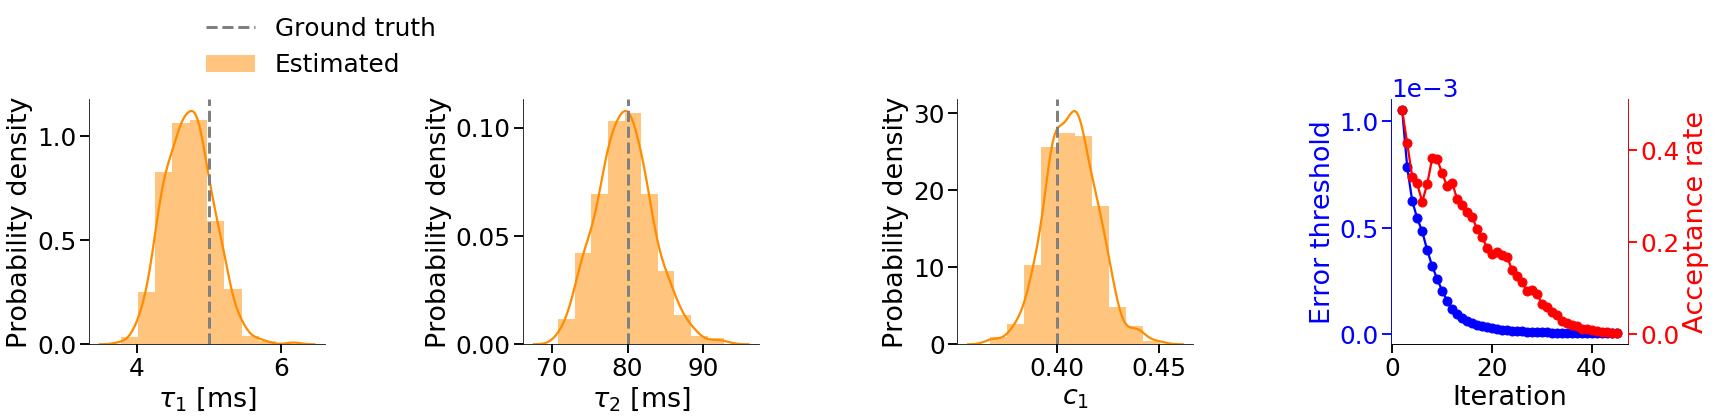

In [4]:
# plot the results
fig = plt.figure(figsize = (24,6))

# plotting variables
cABC = 'darkorange'
ctheor = 'gray'
cAccR = 'r'
cErr = 'b'
a = 0.5
lw = 3

ax = plt.subplot(141)
ax.hist(tau1, facecolor= cABC, density=True, alpha = a, label = r'Estimated')
sns.kdeplot(tau1, data2=None, shade=False, vertical=False, color = cABC)
plt.axvline(tau1_gt, color = ctheor, label = r'Ground truth', linewidth = lw, linestyle = '--')

ax.set_xlabel(r'$\tau_1$ [ms]')
ax.set_ylabel('Probability density')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon = False, bbox_to_anchor=(0.4, 1))

ax = plt.subplot(142)
ax.hist(tau2, facecolor= cABC, density=True, alpha = a, label = r'Estimated')
sns.kdeplot(tau2, data2=None, shade=False, vertical=False, color = cABC)
plt.axvline(tau2_gt, color = ctheor, label = r'Ground truth', linewidth = lw, linestyle = '--')
ax.set_xlabel(r'$\tau_2$ [ms]')
ax.set_ylabel('Probability density')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(143)
ax.hist(c1, facecolor= cABC, density=True, alpha = a, label = r'Estimated')
sns.kdeplot(c1, data2=None, shade=False, vertical=False, color = cABC)
plt.axvline(c1_gt, color = ctheor, label = r'Ground truth', linewidth = lw, linestyle = '--')
ax.set_xlabel(r'$c_1$')
ax.set_ylabel('Probability density')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(144)
ax.plot(steps,eps,'-o', color = cErr)
ax.set_xlabel('Iteration')
ax.set_ylabel('Error threshold', color = cErr)
plt.ticklabel_format(axis="y", style="sci", scilimits= (0,0))

ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax5 = ax.twinx()
ax5.plot(steps, accR,'-o', color = cAccR)
ax5.set_ylabel('Acceptance rate', color = cAccR)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_color(cAccR)
ax5.spines['left'].set_color(cErr)
ax5.tick_params(axis='y', colors=cAccR)
ax.tick_params(axis='y', colors=cErr)


fig.tight_layout()

# Compute MAP estimates

In [5]:
# load abc results
data_abc_path = 'example_abc_results/'
filename = '2on_inhomPois_tau5_80_T1000_lag110_steps45'
abc_results = np.load(data_abc_path + filename + '.npy', allow_pickle=True)
ind = filename.find('steps') 
final_step = int(filename[ind+5] + filename[ind+6])

# extract estimated parameters
theta_accepted = abc_results[final_step-1]['theta accepted']

# find MAPs
N = 20000 # number of samples for grid search
theta_MAP = abcTau.find_MAP(theta_accepted, N)
print(theta_MAP)

[ 4.55057826 78.41096471  0.40526876]


# Perform Bayesian model comparison

Run the model comparison module for fitted models with aABC algorithm.

In [6]:
# load abc fits 
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

file = '1on_inhomPois_tau5_80_T1000_lag110_steps29.npy'
abc_results1 = np.load(datasave_path + file, allow_pickle=True) 
ind = file.find('steps') 
final_step1 = int(file[ind+5] + file[ind+6])


file = '2on_inhomPois_tau5_80_T1000_lag110_steps45.npy'
abc_results2 = np.load(datasave_path + file, allow_pickle=True) 
ind = file.find('steps') 
final_step2 = int(file[ind+5] + file[ind+6])


# load real data and set fitting params
filename = 'inhomPois_tau5_80_coeff04_T1000_trials500_deltaT1_data_mean1_data_var1.25'
real_data = np.load(dataload_path + filename + '.npy')

deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
maxTimeLag = 110 # maximum time-lag


# set the generative models, summary statistic metric and distance functions
model1 = 'oneTauOU_poissonSpikes'
model2 = 'twoTauOU_poissonSpikes'
distFunc = 'linear_distance'
summStat_metric = 'comp_ac_fft'
ifNorm = True # normalize the autocorrelations to the zero time-lag

# set the values if any of the models used disperssion parameters from the grid search method
disp1 = None # disperssion for model1
disp2 = None # disperssion for model1


# set parameters for computing CDFs
eval_start = 3 # number of smallest errors we ignore before starting CDF computation.
numSamplesModelComp = 1000 # number of samples from posterior distributions to compute the Bayes factor.

d1, d2, cdf1, cdf2, err_threshs, bf = \
abcTau.model_comp(real_data, deltaT, binSize, maxTimeLag, abc_results1,final_step1, abc_results2, final_step2,\
              model1, model2, distFunc, summStat_metric, ifNorm, numSamplesModelComp, eval_start, disp1, disp2)

Computing distances for model1:
Sample  0
Sample  1
Sample  2
Sample  3
Sample  4
Sample  5
Sample  6
Sample  7
Sample  8
Sample  9
Sample  10
Sample  11
Sample  12
Sample  13
Sample  14
Sample  15
Sample  16
Sample  17
Sample  18
Sample  19
Sample  20
Sample  21
Sample  22
Sample  23
Sample  24
Sample  25
Sample  26
Sample  27
Sample  28
Sample  29
Sample  30
Sample  31
Sample  32
Sample  33
Sample  34
Sample  35
Sample  36
Sample  37
Sample  38
Sample  39
Sample  40
Sample  41
Sample  42
Sample  43
Sample  44
Sample  45
Sample  46
Sample  47
Sample  48
Sample  49
Sample  50
Sample  51
Sample  52
Sample  53
Sample  54
Sample  55
Sample  56
Sample  57
Sample  58
Sample  59
Sample  60
Sample  61
Sample  62
Sample  63
Sample  64
Sample  65
Sample  66
Sample  67
Sample  68
Sample  69
Sample  70
Sample  71
Sample  72
Sample  73
Sample  74
Sample  75
Sample  76
Sample  77
Sample  78
Sample  79
Sample  80
Sample  81
Sample  82
Sample  83
Sample  84
Sample  85
Sample  86
Sample  87
Sample  88

Sample  691
Sample  692
Sample  693
Sample  694
Sample  695
Sample  696
Sample  697
Sample  698
Sample  699
Sample  700
Sample  701
Sample  702
Sample  703
Sample  704
Sample  705
Sample  706
Sample  707
Sample  708
Sample  709
Sample  710
Sample  711
Sample  712
Sample  713
Sample  714
Sample  715
Sample  716
Sample  717
Sample  718
Sample  719
Sample  720
Sample  721
Sample  722
Sample  723
Sample  724
Sample  725
Sample  726
Sample  727
Sample  728
Sample  729
Sample  730
Sample  731
Sample  732
Sample  733
Sample  734
Sample  735
Sample  736
Sample  737
Sample  738
Sample  739
Sample  740
Sample  741
Sample  742
Sample  743
Sample  744
Sample  745
Sample  746
Sample  747
Sample  748
Sample  749
Sample  750
Sample  751
Sample  752
Sample  753
Sample  754
Sample  755
Sample  756
Sample  757
Sample  758
Sample  759
Sample  760
Sample  761
Sample  762
Sample  763
Sample  764
Sample  765
Sample  766
Sample  767
Sample  768
Sample  769
Sample  770
Sample  771
Sample  772
Sample  773
Samp

Sample  381
Sample  382
Sample  383
Sample  384
Sample  385
Sample  386
Sample  387
Sample  388
Sample  389
Sample  390
Sample  391
Sample  392
Sample  393
Sample  394
Sample  395
Sample  396
Sample  397
Sample  398
Sample  399
Sample  400
Sample  401
Sample  402
Sample  403
Sample  404
Sample  405
Sample  406
Sample  407
Sample  408
Sample  409
Sample  410
Sample  411
Sample  412
Sample  413
Sample  414
Sample  415
Sample  416
Sample  417
Sample  418
Sample  419
Sample  420
Sample  421
Sample  422
Sample  423
Sample  424
Sample  425
Sample  426
Sample  427
Sample  428
Sample  429
Sample  430
Sample  431
Sample  432
Sample  433
Sample  434
Sample  435
Sample  436
Sample  437
Sample  438
Sample  439
Sample  440
Sample  441
Sample  442
Sample  443
Sample  444
Sample  445
Sample  446
Sample  447
Sample  448
Sample  449
Sample  450
Sample  451
Sample  452
Sample  453
Sample  454
Sample  455
Sample  456
Sample  457
Sample  458
Sample  459
Sample  460
Sample  461
Sample  462
Sample  463
Samp

/Users/roxanazeraati/ownCloud/Projects/Attention_MT_clean/toolbox/abcTau_package_psd/abcTau/model_comparison.py:224: RuntimeWarning: divide by zero encountered in true_divide
  bf = np.array(cdf2)/np.array(cdf1)


Plot CDFs, Bayes factors and report the selected model

Two timescales better describe the data.


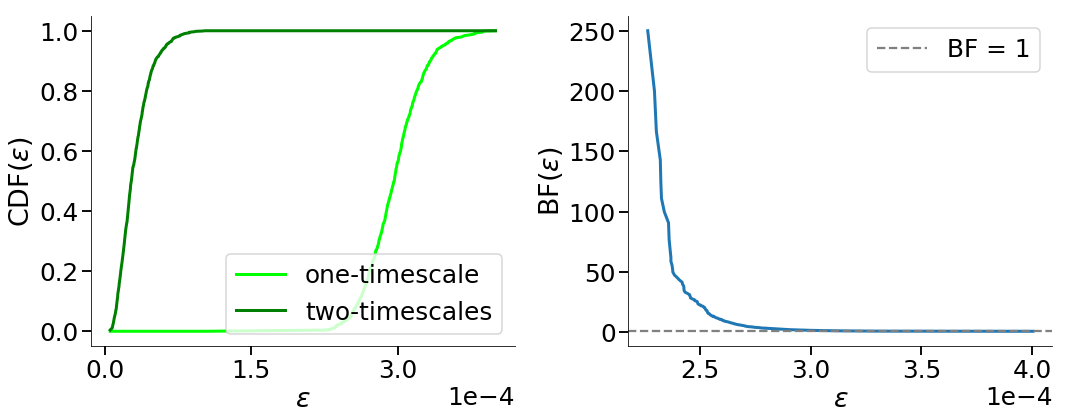

In [7]:
fig = plt.figure(figsize = (15,6))
c2 = 'g'
c1 = 'lime'
lw = 3

ax = plt.subplot(121)
plt.plot(err_threshs, cdf1, color = c1, linewidth = lw, label = 'one-timescale')
plt.plot(err_threshs, cdf2, color = c2, linestyle = '-', linewidth = lw, label = 'two-timescales')
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'CDF$(\varepsilon)$')
ax.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


ax = plt.subplot(122)
plt.plot(err_threshs, bf, linewidth = lw)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.axhline(1, color = 'gray', linestyle = '--', label = 'BF = 1')
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'BF$(\varepsilon)$')
ax.legend()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

# Due to the noisiness of data threshold on bf can also be set to values close to 1 like 0.9.
bf_thresh = 1
if np.sum(np.where(bf < bf_thresh)) == 0:
    print('Two timescales better describe the data.')



Plot CDFs, Bayes factors and report the selected model from previously saved distances of models

In [8]:
# load computed distances for each model
data_abc_path = 'example_modelComparison/'
d2 = np.load(data_abc_path + 'dABC_linDist_2on_dbSpikes_5_80_b1_a05_T1000_timeLag110.npy')
d1 = np.load(data_abc_path + 'dABC_linDist_1on_dbSpikes_5_80_b1_a05_T1000_timeLag110.npy')

numSamplesModelComp = 1000 # number of samples from posterior distributions to compute the Bayes factor.
cdf1, cdf2, err_threshs, bf = abcTau.comp_cdf(d1, d2, numSamplesModelComp, eval_start = 3)

Two timescales better describe the data.


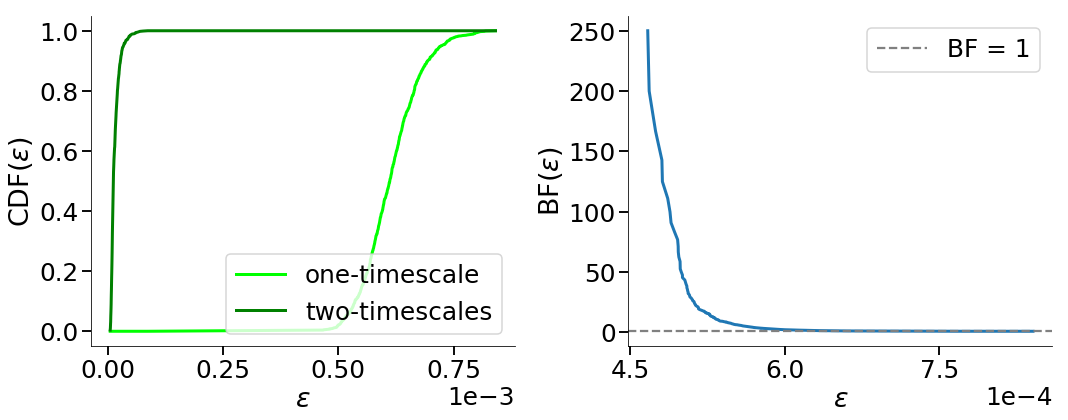

In [9]:
fig = plt.figure(figsize = (15,6))
c2 = 'g'
c1 = 'lime'
lw = 3

ax = plt.subplot(121)
plt.plot(err_threshs, cdf1, color = c1, linewidth = lw, label = 'one-timescale')
plt.plot(err_threshs, cdf2, color = c2, linestyle = '-', linewidth = lw, label = 'two-timescales')
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'CDF$(\varepsilon)$')
ax.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


ax = plt.subplot(122)
plt.plot(err_threshs, bf, linewidth = lw)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.axhline(1, color = 'gray', linestyle = '--', label = 'BF = 1')
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'BF$(\varepsilon)$')
ax.legend()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

# Due to the noisiness of data threshold on bf can also be set to values close to 1 like 0.9.
bf_thresh = 1
if np.sum(np.where(bf < bf_thresh)) == 0:
    print('Two timescales better describe the data.')
